# PIMA

This Machine Learning project determines if a patient has diabetes.

The dataset is filled with medical information of indian female patients.

## Summary

* Data visualisation
* Logistic Regression
* Decision Tree
* Random Forest

# Library used

In [41]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

# Machine Learning Library
import joblib
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

# Data

In [4]:
data = pd.read_csv("./resources/diabetes.csv", encoding='utf-8', sep=',')
data.drop_duplicates()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Missing values

In [14]:
(data.isnull().sum()/data.shape[0])*100

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

There is no missing values in the data.

## Balance of Target data

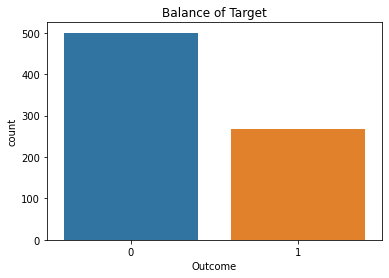

Unbalanced data on the 'Outcome' column:
0    500
1    268
Name: Outcome, dtype: int64


In [11]:
fig = sns.countplot(x="Outcome", data=data)
plt.title('Balance of Target')
plt.show()
print("Unbalanced data on the 'Outcome' column:")
print(data['Outcome'].value_counts())

The data is slightly imbalanced, this might be an issue for our machine learning models later on.

## Outliers

In [21]:
fig = px.box(data, y= ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
fig.show()

The Insulin column has a lot of outliers, they might be the result of errors when entering the data.

## Correlation

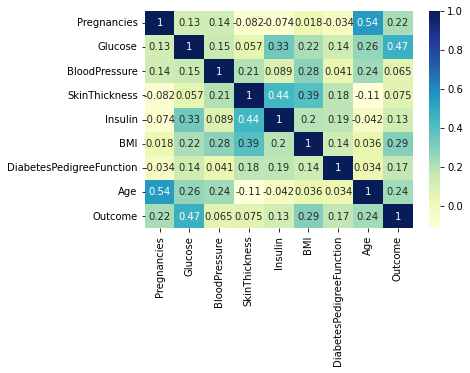

In [27]:
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

## Pairplots

In [31]:
fig = px.scatter_matrix(data,
    dimensions=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness'],
    color="Outcome")
fig.show()

In [32]:
 fig = px.scatter_matrix(data,
    dimensions=['Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'],
    color="Outcome")
fig.show()

# Splitting data into training and testings sets

In [34]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
print('Patient characteristics columns:\n\n', X.head(), '\n')
print('Diabetes Outcome:\n\n', y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Patient characteristics columns:

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33   

Diabetes Outcome:

 0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64


# Logistic Regression

In [35]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

## Model testing

In [36]:
predictions = LR.predict(X_test)
print("Predictions:\n\n", predictions, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 0] 

Real values:

 668    0
324    0
624    0
690    0
473    0
      ..
619    1
198    1
538    0
329    0
302    0
Name: Outcome, Length: 231, dtype: int64


## Model Evaluation

In [37]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       151
           1       0.62      0.62      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231



In [38]:
print("Accuracy score:", round((accuracy_score(y_test, predictions)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(LR, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 74.03 %

Accuracy score using cross validation: 76.91 %



In [40]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

NameError: name 'confusion_matrix' is not defined